In [1]:
import numpy as np

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

from copy import deepcopy as copy
# np.random.seed(1)

In [2]:
!pip install git+https://github.com/kilean20/pyTorchTemplate.git

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/kilean20/pyTorchTemplate.git to /tmp/pip-req-build-eh2thl1s
  Running command git clone -q https://github.com/kilean20/pyTorchTemplate.git /tmp/pip-req-build-eh2thl1s
  Created wheel for pyTorchTemplate: filename=pyTorchTemplate-0.0.1-py3-none-any.whl size=6602 sha256=3153e2074a78b00fce3b9ce87ed91abcd479720126795f97715b794d5fd4c21e
  Stored in directory: /tmp/pip-ephem-wheel-cache-dunetchu/wheels/15/b3/6d/10ca0e96789eddf8cbd29d87914215e75608e6930926678261
Successfully built pyTorchTemplate


In [3]:
!pip install git+https://github.com/kilean20/pyTorchTemplate.git --upgrade

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/kilean20/pyTorchTemplate.git to /tmp/pip-req-build-i6d8rnx6
  Running command git clone -q https://github.com/kilean20/pyTorchTemplate.git /tmp/pip-req-build-i6d8rnx6
  Created wheel for pyTorchTemplate: filename=pyTorchTemplate-0.0.1-py3-none-any.whl size=6602 sha256=c736a76907deb33b699e24bd219b634fbb4e317e455a2653b367f1370f825e46
  Stored in directory: /tmp/pip-ephem-wheel-cache-i05x6piq/wheels/15/b3/6d/10ca0e96789eddf8cbd29d87914215e75608e6930926678261
Successfully built pyTorchTemplate
  Attempting uninstall: pyTorchTemplate
    Found existing installation: pyTorchTemplate 0.0.1
    Uninstalling pyTorchTemplate-0.0.1:
      Successfully uninstalled pyTorchTemplate-0.0.1


In [4]:
import torch
import pyTorchTemplate as ptt
device = ptt.device

In [5]:
import matplotlib.pyplot as plt

In [6]:
d = 6
n = 2048  #number of samples
nPrior = n*100
p = 8

# Function to fit

$$
\begin{eqnarray}
R &=& |\boldsymbol{x}| \\
{f} &=& \frac{\sin(4\pi R)}{4\pi R}
\end{eqnarray}
$$

In [7]:
def f(x):
    """The function to predict."""
    
    R = np.sqrt(np.sum(x**2,axis=1)) + 0.0001
    return np.sin(4*np.pi*R)/(4*np.pi*R)

In [8]:
x_train = ((np.random.rand(n,d)-0.5)*2).astype(np.float32)
y_train = f(x_train)

x_test = ((np.random.rand(n,d)-0.5)*2).astype(np.float32)
y_test = f(x_test)

x_onAxis = np.zeros([128,d],dtype=np.float32)
x_onAxis[:,0] = np.linspace(-1, 1, 128)
y_onAxis = f(x_onAxis)

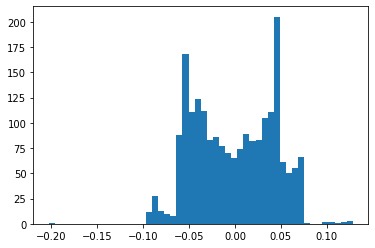

In [9]:
plt.hist(y_train,bins=50);

### GP fit

### without Prior model

In [10]:
kernel = C(1.0, (2e-2, 10.0)) * RBF(1, (2e-2, 1.0))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

In [11]:
gp.score(x_train, y_train), gp.score(x_test, y_test)

(-0.0006529105152890402, -0.0008166961444535659)

In [12]:
gp.fit(x_train, y_train)
gp.kernel_

/usr/common/software/pytorch/v1.4.0/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


0.141**2 * RBF(length_scale=0.437)

In [13]:
gp.score(x_train, y_train), gp.score(x_test, y_test)  
# score over test data after train can become even worse when train data is not enough !!

(0.9999999999999979, -0.9622522300094052)

In [14]:
y_pred, sigma = gp.predict(x_onAxis, return_std=True)

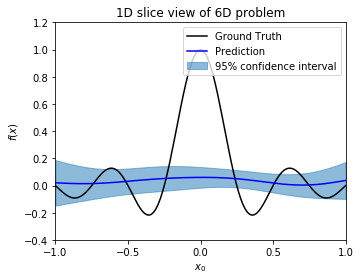

In [15]:
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111)

ax.plot(x_onAxis[:,0],y_onAxis ,'k', label='Ground Truth')
ax.plot(x_onAxis[:,0],y_pred,   'b-', label='Prediction')
ax.fill_between(x_onAxis[:,0], y_pred- 1.96 * sigma,
                               y_pred+ 1.96 * sigma, 
                label='95% confidence interval', color='C0', alpha=.5, )

plt.title('1D slice view of '+str(d)+'D problem')
plt.xlabel(r'$x_0$')
plt.ylabel(r'$f(x)$')
plt.legend(loc='upper right')
plt.tight_layout()
plt.xlim(-1,1)
plt.ylim(-0.4,1.2)
plt.xticks([-1,-0.5,0,0.5,1])
plt.savefig('GP'+str(d)+'D_'+str(n)+'sample.png',dpi=180)

## with Prior model
Model true prior
$$
f_{0}(\boldsymbol{x})=f(\boldsymbol{x}) + a(\boldsymbol{x})\sin\phi(\boldsymbol{x}) + b(\boldsymbol{x})
$$

where $a(\boldsymbol{x})$, $\phi(\boldsymbol{x})$ and $b(\boldsymbol{x})$ are modeled using randomized neural network

In [16]:
amp_func = torch.nn.Sequential(torch.nn.Linear(d,32),
                               torch.nn.CELU(),
                               torch.nn.Linear(32,32),
                               torch.nn.CELU(),
                               torch.nn.Linear(32,1))

phase_func = torch.nn.Sequential(torch.nn.Linear(d,32),
                                 torch.nn.CELU(),
                                 torch.nn.Linear(32,32),
                                 torch.nn.CELU(),
                                 torch.nn.Linear(32,1))

bias_func = torch.nn.Sequential(torch.nn.Linear(d,32),
                                torch.nn.CELU(),
                                torch.nn.Linear(32,32),
                                torch.nn.CELU(),
                                torch.nn.Linear(32,1))

In [17]:
# model.state_dict()['0.weight'].copy_(model.state_dict()['0.weight']);
# model.state_dict()['0.bias'].copy_(model.state_dict()['0.bias']);
# model.state_dict()['2.weight'].copy_(model.state_dict()['2.weight']);
# model.state_dict()['2.bias'].copy_(model.state_dict()['2.bias']);

In [18]:
def f0(x):
    """The approximate function to predict."""
    f0 = f(x)
    amp = amp_func(torch.Tensor(2*x+2)).detach().numpy().ravel()
    phase = phase_func(torch.Tensor(10*x+2)).detach().numpy().ravel()
    bias = bias_func(torch.Tensor(2*x+2)).detach().numpy().ravel()
    
    return f0+0.7*(0.5*f0+amp)*np.sin(5*phase)-0.7*bias

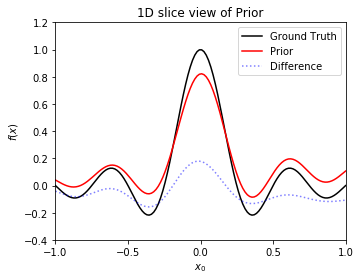

In [19]:
fig = plt.figure(figsize=(5,4))

plt.plot(x_onAxis[:,0],y_onAxis ,'k' , label='Ground Truth')
plt.plot(x_onAxis[:,0],f0(x_onAxis),'r', label='Prior')
plt.plot(x_onAxis[:,0],y_onAxis-f0(x_onAxis),'b:', label='Difference',alpha=0.5)


plt.title('1D slice view of Prior')
plt.xlabel(r'$x_0$')
plt.ylabel(r'$f(x)$')
plt.legend(loc='upper right')
plt.tight_layout()
plt.xlim(-1,1)
plt.ylim(-0.4,1.2)
plt.xticks([-1,-0.5,0,0.5,1])
plt.savefig('Prior_'+str(d)+'D_SliceView.png',dpi=180)

using rough estimated data, we build the approximate prior close to the true prior

In [20]:
xPrior_train = ((np.random.rand(nPrior,d)-0.5)*2).astype(np.float32)
yPrior_train = f0(xPrior_train).reshape(-1,1).astype(np.float32)
train_data_loader = torch.utils.data.DataLoader(list(zip(xPrior_train,yPrior_train)),batch_size=128*100)

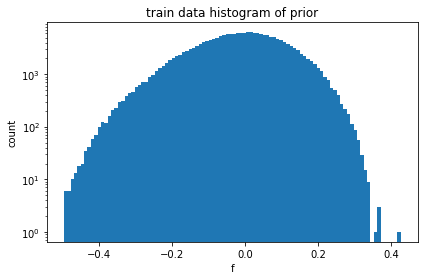

In [21]:
hist = plt.hist(yPrior_train,bins=100);
plt.xlabel('f')
plt.ylabel('count')
plt.title('train data histogram of prior')
# plt.xlim(yPrior_train.min(),yPrior_train.max())
plt.yscale('log')
plt.tight_layout()
plt.savefig('prior_train_data_histo_'+str(d)+'D_'+str(nPrior)+'sample.png',dpi=180)

In [22]:
def test(model,criterion,test_data_loader):
  model.eval()
  loss = 0 
  for x, y in test_data_loader:
    x = x.to(device)
    y_pred = model(x)
    loss += criterion(y_pred, y.to(device)).item()
  return loss/len(test_data_loader)

In [ ]:
old_best_loss = 1
for i in range(10):
  model = ptt.resFCNN([d,128,128,1], torch.nn.CELU(inplace=True))
  mode,hist = ptt.train_supervised(model,1.0e-2,10,
                                  train_data_loader,
                                  optimizer=torch.optim.Adam,
                                  criterion=ptt.MPELoss(p=p),
                                  old_best_loss = old_best_loss,
                                  dispHead = 0, dispTail = 0)
  newloss = test(model,ptt.MPELoss(p=p),train_data_loader)
  if newloss > 2e-4:
    continue
  mode,hist = ptt.train_supervised(model,3.3e-3,20,
                                  train_data_loader,
                                  optimizer=torch.optim.Adam,
                                  criterion=ptt.MPELoss(p=p),
                                  old_hist = hist,
                                  old_best_loss = old_best_loss,
                                  dispHead = 0, dispTail = 0)
  newloss = test(model,ptt.MPELoss(p=p),train_data_loader)
  if newloss > 2e-5:
    continue
  mode,hist = ptt.train_supervised(model,1.0e-3,30,
                                  train_data_loader,
                                  optimizer=torch.optim.Adam,
                                  criterion=ptt.MPELoss(p=p),
                                  old_hist = hist,
                                  old_best_loss = old_best_loss,
                                  dispHead = 0, dispTail = 0)
  newloss = test(model,ptt.MPELoss(p=p),train_data_loader)
  
  if newloss < old_best_loss:
    old_best_loss = newloss
    final_model = copy(model)
    final_hist  = copy(hist)
    
  if newloss < 3e-6:
    break
    
  plt.figure(figsize=(4,2))
  plt.semilogy(hist['train_loss'])
  plt.semilogy(hist['test_loss'])

model = final_model
hist = final_hist
mode,hist = ptt.train_supervised(model,1.0e-4,40,
                                train_data_loader,
                                optimizer=torch.optim.Adam,
                                criterion=ptt.MPELoss(p=p),
                                old_hist = hist,
                                old_best_loss = newloss,
                                dispHead = 0, dispTail = 0)
newloss = test(model,ptt.MPELoss(p=p),train_data_loader)


model = model.cpu()
model.eval();

In [ ]:
plt.semilogy(hist['train_loss'])

In [ ]:
def f1(x):
    return model(torch.Tensor(x)).detach().numpy().flatten()

y_train = f(x_train) -f1(x_train)

y_test = f(x_test) -f1(x_test)

In [ ]:
fig = plt.figure(figsize=(5,4))

plt.plot(x_onAxis[:,0],y_onAxis ,'k' , label='Ground Truth')
plt.plot(x_onAxis[:,0],f0(x_onAxis),'r:', label='Prior',alpha=0.7)
plt.plot(x_onAxis[:,0],f1(x_onAxis),'r', label='Data Driven Prior')
plt.plot(x_onAxis[:,0],y_onAxis-f1(x_onAxis),'b:', label='Difference',alpha=0.5)


plt.title('1D slice view of Prior')
plt.xlabel(r'$x_0$')
plt.ylabel(r'$f(x)$')
plt.legend(loc='upper right')
plt.tight_layout()
plt.xlim(-1,1)
plt.ylim(-0.4,1.2)
plt.xticks([-1,-0.5,0,0.5,1])
plt.savefig('DataDrivenPrior_'+str(d)+'D_SliceView.png',dpi=180)

In [ ]:
kernel = C(1.0, (1e-1, 10.0)) * RBF(1, (2e-2, 1.0))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=3, alpha=0.1)

In [ ]:
gp.score(x_train, y_train), gp.score(x_test, y_test)

In [ ]:
gp.fit(x_train, y_train)
gp.kernel_

In [ ]:
gp.score(x_train, y_train), gp.score(x_test, y_test)  
# score over test data after train can become even worse when train data is not enough !!

In [ ]:
y_pred, sigma = gp.predict(x_onAxis, return_std=True)

In [ ]:
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111)

ax.plot(x_onAxis[:,0],y_onAxis           ,'k' , label='Ground Truth')
ax.plot(x_onAxis[:,0],f1(x_onAxis)       ,'r',  label='Data Driven Prior')
ax.plot(x_onAxis[:,0],f1(x_onAxis)+y_pred,'b-', label='Prediction')
ax.fill_between(x_onAxis[:,0], 
                f1(x_onAxis)+y_pred- 1.96 * sigma,
                f1(x_onAxis)+y_pred+ 1.96 * sigma, 
                label='95% confidence interval', color='C0', alpha=.5, )

plt.title('1D slice view of '+str(d)+'D problem with data driven prior')
plt.xlabel(r'$x_0$')
plt.ylabel(r'$f(x)$')
plt.legend(loc='upper right')
plt.tight_layout()
plt.xlim(-1,1)
plt.ylim(-0.4,1.2)
plt.xticks([-1,-0.5,0,0.5,1])
plt.savefig('GP_wDataDrivenPrior_'+str(d)+'D_'+str(n)+'sample_'+str(nPrior)+'priorSample.png',dpi=180)